In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from collections import defaultdict
from tensorflow.keras.models import load_model

# Load your model if it's not already loaded
model = load_model('/Users/bahij/Desktop/Multimodal Emotion Recognition/models/resnet50/resnet50_emotion_classifier.h5')

# Define directories for your dataset
train_dir = '/Users/bahij/Desktop/Multimodal Emotion Recognition/datasets/train'
test_dir = '/Users/bahij/Desktop/Multimodal Emotion Recognition/datasets/test'

# Function to load images and labels from a directory and balance the dataset
def load_images_and_labels(directory, exclude_emotions=None, balance=False):
    images = []
    labels = []
    class_counts = defaultdict(int)
    min_samples = float('inf')
    
    # Calculate the minimum number of samples among all classes
    for emotion_folder in os.listdir(directory):
        if exclude_emotions and emotion_folder in exclude_emotions:
            continue  # Skip this emotion if it's in the exclusion list
        emotion_path = os.path.join(directory, emotion_folder)
        if os.path.isdir(emotion_path):
            num_samples = len(os.listdir(emotion_path))
            class_counts[emotion_folder] = num_samples
            min_samples = min(min_samples, num_samples)
    
    # Sample the same number of instances for each class to create a balanced dataset if requested
    for emotion_folder, num_samples in class_counts.items():
        emotion_path = os.path.join(directory, emotion_folder)
        if os.path.isdir(emotion_path):
            if balance:  # Balance the dataset by sampling the minimum number of instances per class
                num_samples = min_samples
            for image_file in np.random.choice(os.listdir(emotion_path), num_samples, replace=False):
                image_path = os.path.join(emotion_path, image_file)
                image = load_img(image_path, target_size=(224, 224))
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(emotion_folder)
    
    return np.array(images), np.array(labels)

# Load balanced training and testing images and labels, excluding 'contempt' and 'disgust'
X_train, y_train = load_images_and_labels(train_dir, exclude_emotions=['contempt', 'disgust'], balance=True)
X_test, y_test = load_images_and_labels(test_dir, exclude_emotions=['contempt', 'disgust'], balance=False)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 97s 648ms/step


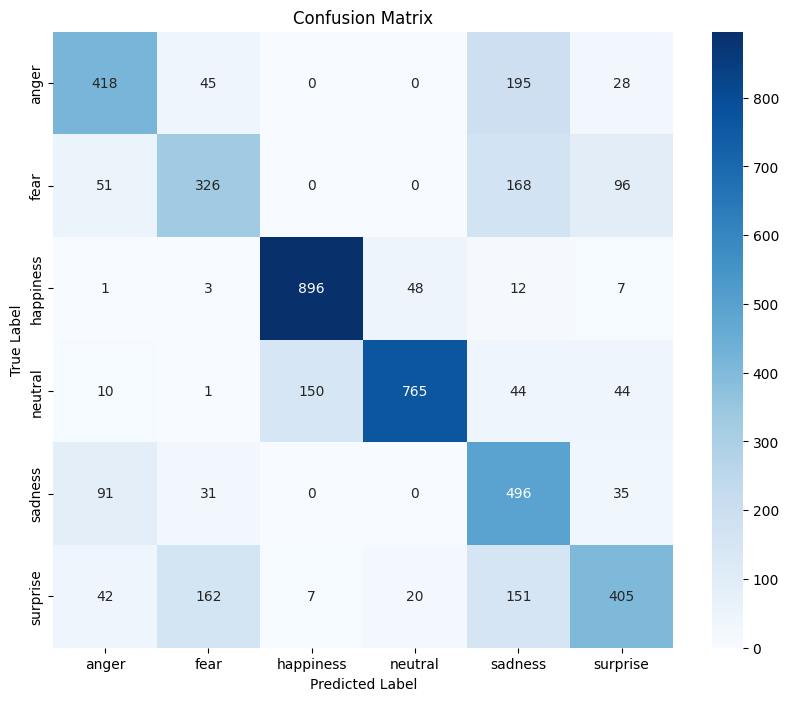

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test_categorical, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [3]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print('Overall Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.61      0.64       686
        fear       0.57      0.51      0.54       641
   happiness       0.85      0.93      0.89       967
     neutral       0.92      0.75      0.83      1014
     sadness       0.47      0.76      0.58       653
    surprise       0.66      0.51      0.58       787

    accuracy                           0.70      4748
   macro avg       0.69      0.68      0.68      4748
weighted avg       0.72      0.70      0.70      4748

Overall Accuracy: 0.6962931760741364
